In [77]:
import tensorflow as tf
from keras.losses import mean_squared_error
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(mean_squared_error(y_true, y_pred))
model = tf.keras.models.load_model("../model/LSTM_3_3.keras", custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [78]:
from pandas import read_csv
#Load data set
look_back = 2
series_influ_A_df = read_csv('../temp_data/influA_vietnam.csv', usecols=[1,2,3], engine='python')
train_df = series_influ_A_df.iloc[0:780]
test_df = series_influ_A_df.iloc[780-look_back:]
# series_influ_A_df = series_influ_A_df["Influenza A - All types of surveillance"]
series_influ_A_df = series_influ_A_df.dropna()
series_influ_A_df = series_influ_A_df.astype('float32')
series_influ_A_df = series_influ_A_df.values
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(series_influ_A_df)
# Create Training and Test

train = dataset[:780, :]
test = dataset[780-look_back:, :]

In [79]:
import numpy as np
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [80]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

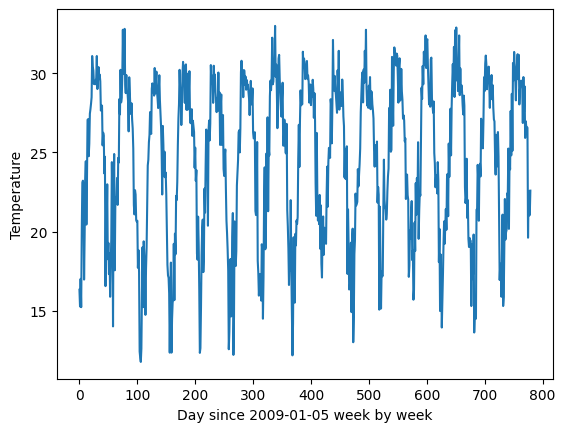

In [81]:
import matplotlib.pyplot as plt
plt.plot(train_df['temp'])
plt.xlabel("Day since 2009-01-05 week by week")
plt.ylabel("Temperature")
plt.show()

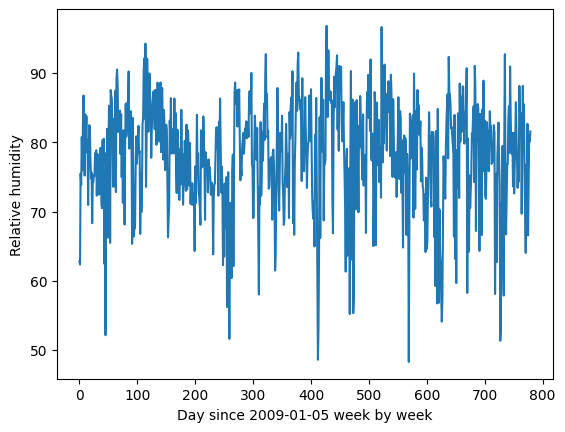

In [82]:
import matplotlib.pyplot as plt
plt.plot(train_df['humidity'])
plt.xlabel("Day since 2009-01-05 week by week")
plt.ylabel("Relative humidity")
plt.show()

In [83]:
# plt.matshow(train_df.corr())
# plt.show()
train_df.corr()

,Influenza A - All types of surveillance,temp,humidity
Influenza A - All types of surveillance,1.000000,0.187628,0.009774
temp,0.187628,1.000000,0.147791
humidity,0.009774,0.147791,1.000000


In [84]:
from sklearn.metrics import mean_squared_error
# [[1,3]] :shape 1,2
def predict_one(X, model):
    X= np.array([X])
    predicted = model.predict(X, verbose=0)
    return predicted[0]


#X_start: [[1,3]]
def predict(X_start, num_weeks, model):
    result = []
    X=np.array([X_start])
    for i in range(num_weeks):
        predicted = predict_one(X[i], model)
        result.append(predicted)
        X_continue = np.vstack((X[-1][-1], predicted.reshape(1,3)))
        X = np.append(X, [X_continue], axis=0)
    import json
    # with open('./X.json', 'w') as f:
    #     json.dump(X.tolist(), f)
    return result
    
# make predictions
# testPredict = model.predict(testX)
testPredict = predict(testX[0], len(test)-look_back, model)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform(testY)
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY_, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 10.53 RMSE


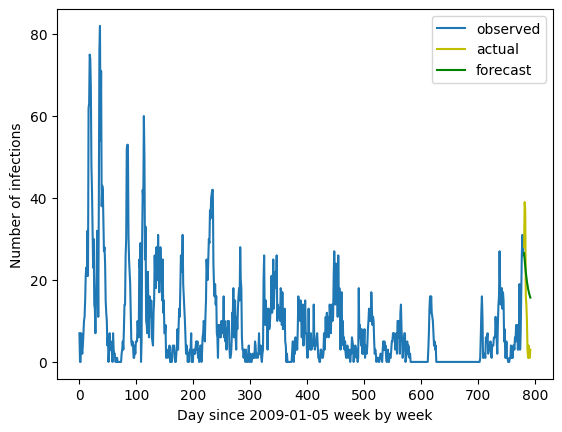

In [85]:

# (x,3)
testPredictPlot = np.empty([dataset.shape[0]])
testPredictPlot[:] = np.nan
testPredictPlot[len(train):len(dataset)] = testPredict[:,0].reshape(-1)
testPlot = np.empty([dataset.shape[0]])
testPlot[:] = np.nan
testPlot[len(train):len(dataset)] = scaler.inverse_transform(test[look_back:])[:,0].reshape(-1)
plt.plot(scaler.inverse_transform(train)[:,0].reshape(-1), label="observed")
plt.plot(testPlot, "-y", label="actual")
plt.plot(testPredictPlot, color = 'green', label="forecast")
plt.xlabel("Day since 2009-01-05 week by week")
plt.ylabel("Number of infections")
plt.legend(["observed", "actual", "forecast"])
plt.show()

In [86]:
print(scaler.inverse_transform(test[look_back:]))


[[27.999998 14.542857 56.014282]
 [39.       18.985714 69.      ]
 [37.       21.314285 78.442856]
 [16.       19.757143 90.85714 ]
 [13.999999 20.928572 86.98572 ]
 [10.       11.314286 70.457146]
 [ 3.       18.757143 89.27143 ]
 [ 1.       17.914286 76.25714 ]
 [ 4.       21.157143 81.58572 ]
 [ 1.       20.3      91.78571 ]
 [ 1.       14.4      79.7     ]
 [ 3.       20.157143 81.25714 ]]


In [59]:
print(testPredict)


[[26.87548612 23.20284386 83.31534298]
 [25.25230824 24.20710084 82.05943318]
 [23.45313344 24.04848966 81.44986021]
 [21.85944478 24.18619849 81.04148662]
 [20.33898063 24.15126271 80.88292795]
 [18.92791521 24.12458774 80.77552942]
 [17.60382429 24.05980718 80.72577769]
 [16.36543344 23.98242278 80.69452043]
 [15.20491153 23.89103813 80.67752513]
 [14.1174223  23.79140775 80.66683863]
 [13.09785701 23.68563982 80.66017047]
 [12.14184982 23.57618785 80.65552779]]
